# An introduction to the Session object

This is a quick notebook showing off the Sherpa session API. This is the code that makes the UI layer (either `sherpa.astro.ui` or `sherpa.ui`) work, but in these modules it is hidden away.

## Author and disclaimer

This was written by 
[Douglas Burke](http://hea-www.cfa.harvard.edu/~dburke/)
on January 31 2017. This notebook, and others that may be of interest, can be found on GitHub at
https://github.com/DougBurke/sherpa-standalone-notebooks. It has since been updated to match changes in Sherpa.

The information in this document is placed into the Publc Domain. It is not an official product of the Chandra X-ray Center, and I make no guarantee that it is not without bugs or embarassing typos. Please contact me via the GitHub repository
if you have any questions.

## Last run

Let's start off by seeing when I last ran this notebook

In [1]:
import datetime
datetime.datetime.now().strftime("%Y-%m-%d %H:%M")

'2025-10-01 13:01'

and what version of Sherpa is being used (the 'full' key represents the git commit used to build this version of Sherpa):

In [2]:
import sherpa
print(sherpa._version.get_versions())

{'date': '2025-09-29T09:22:24-0400', 'dirty': False, 'error': None, 'full-revisionid': '5317ba1bd9c20c5d482e399cdac71d8eb7fde83b', 'version': '4.18.0.rc1'}


## What is the Session object for?

The Session object provides the state management code used by the UI layer; that is either of the `sherpa.ui` or `sherpa.astro.ui` modules. It is hidden away by these modules, but can be used directly, as shown below. This is useful if you want a (slightly) more Pythonic interface or need to encapsulate your fits, but do not want to use the
lower-level object-oriented API I've described in some of
[my other Sherpa notebooks](https://github.com/DougBurke/sherpa-standalone-notebooks).

## What data is going to be fit?

For this example I'm just going to simulate a simple data set, an off-center one-dimensional gaussian:

In [3]:
import numpy as np
%matplotlib inline

In [4]:
rng = np.random.default_rng(0)
x = np.linspace(-5., 5., 200)
ampl_true = 3
pos_true = 1.3
sigma_true = 0.8
err_true = 0.2
y = ampl_true * np.exp(-0.5 * (x - pos_true)**2 / sigma_true**2)
y += rng.normal(0., err_true, x.shape)

## What does this look like?

I could plot this directly with matplotlib, but as this notebook is all about the Session object, let's start using it. Here I use the basic version, but I could have also said

    from sherpa.astro.ui.utils import Session

In [5]:
from sherpa.ui.utils import Session
s = Session()
print(s)

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


The Session object implements the API used by the `sherpa.ui` and `sherpa.astro.ui` modules, so the approach I am going to take is to call `s.some_long_method_name()` when I previously would have used `ui.some_long_method_name()` (or, 
`some_long_method_name()` if you've been looking at the
[CIAO documentation for Sherpa](http://cxc.harvard.edu/sherpa/), which imports everything into the default namespace).

Using this, I can create a data set and plot it:

In [6]:
s.load_arrays(1, x, y)
print(s.get_data())

name      = 
x         = Float64[200]
y         = Float64[200]
staterror = None
syserror  = None


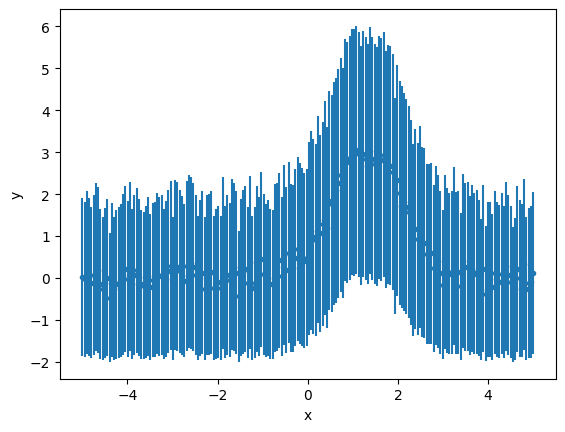

In [7]:
s.plot_data()

Let's get rid of the error bars and try again.

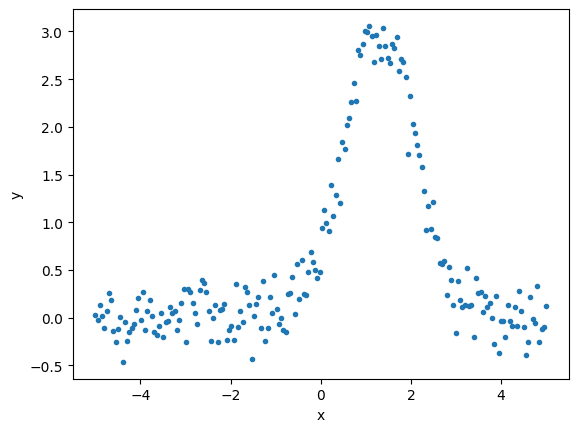

In [8]:
s.get_plot_prefs('data')['yerrorbars'] = False
s.plot_data()

That's a bit better, although I'd prefer the plot to be a bit bigger. Oh well, that can wait for another notebook.

Creating a model component to fit to the data would - using the UI layer, look something like

    ui.set_source(ui.gauss1d.gmdl)
    
but trying

    s.set_source(s.gauss1d.gmdl)
    
just ends up with an error


    AttributeError: 'Session' object has no attribute 'gauss1d'
    
Why is that? Well, let's check what models we have available:

In [9]:
s.list_models()

[]

So, the reason is that we have not registered the Sherpa models with the session object. For this case,
where I only want to use a model from `sherpa.models.basic` I can just say:

In [10]:
s._add_model_types(sherpa.models.basic)

after which the session object contains models:

In [11]:
s.list_models()[0:5]

['box1d', 'box2d', 'const1d', 'const2d', 'cos']

and we can now easily create the model$^\dagger$ (for some reason I can't say `s.set_source(s.gauss1d.gmdl)` so I have to use `create_model_componet`):

---

$^\dagger$ prior to Sherpa 4.12.2 I used to manually create a model, but have switched to using `_add_model_types` to more-closely mirror the `ui` code.

In [12]:
gmdl = s.create_model_component('gauss1d', 'gmdl')
s.set_source(gmdl)
gmdl

<Gauss1D model instance 'gauss1d.gmdl'>

In [13]:
s.set_source(gmdl)

As shown below, the default parameters for the gaussian are not a good match to the data:

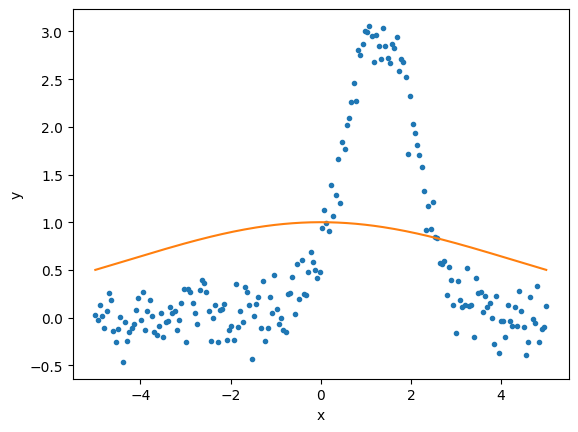

In [14]:
s.plot_fit()

How well does the guess routine do?

gauss1d.gmdl
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   gmdl.fwhm    thawed       1.8593    0.0018593       1859.3           
   gmdl.pos     thawed       1.0804           -5            5           
   gmdl.ampl    thawed      3.05789   0.00305789      3057.89           


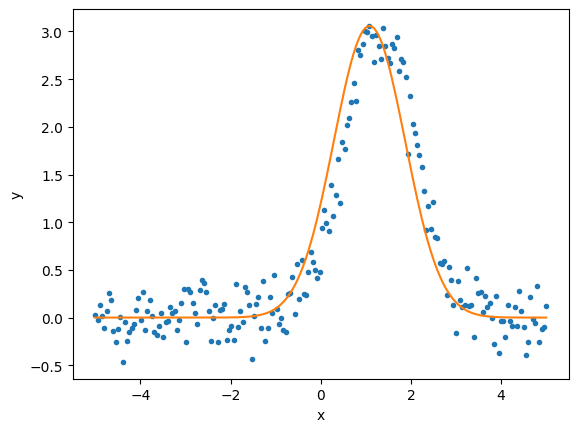

In [15]:
s.guess(gmdl)
print(gmdl)
s.plot_fit()

Prior to the 4.14 release this did not work well, but now it's worked too well!

Let's adjust the FWHM to give us something to fit...

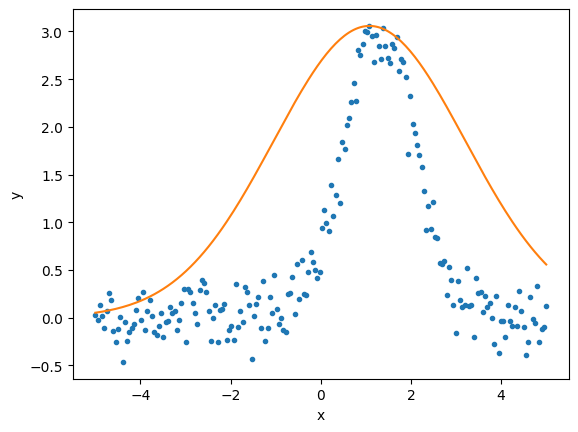

In [16]:
gmdl.fwhm = 5

s.plot_fit()

To fit the model I want to choose a statistic - in this case, as I don't have meaningful errors, I am just going to go for least-squares minimisation

In [17]:
s.set_stat('leastsq')

and an optimiser (which I am going to leave at the default value, which is Levenberg-Marquardt):

In [18]:
print(s.get_method())

name     = levmar
ftol     = 1.1920928955078125e-07
xtol     = 1.1920928955078125e-07
gtol     = 1.1920928955078125e-07
maxfev   = None
epsfcn   = 1.1920928955078125e-07
factor   = 100.0
numcores = 1
verbose  = 0


After this, I can call the `fit` method on the Session object to get a fit:

In [19]:
s.fit()

Dataset               = 1
Method                = levmar
Statistic             = leastsq
Initial fit statistic = 276.38
Final fit statistic   = 7.35617 at function evaluation 25
Data points           = 200
Degrees of freedom    = 197
Change in statistic   = 269.024
   gmdl.fwhm      1.85216      +/- 0.164262    
   gmdl.pos       1.29937      +/- 0.0697554   
   gmdl.ampl      3.02751      +/- 0.232505    


The results can be retrieved programatically, as shown below:

In [20]:
res = s.get_fit_results()
res

Parameter,Best-fit value,Approximate error
gmdl.fwhm,1.85216,± 0.164262
gmdl.pos,1.29937,± 0.0697554
gmdl.ampl,3.02751,± 0.232505


Let's see how it looks:

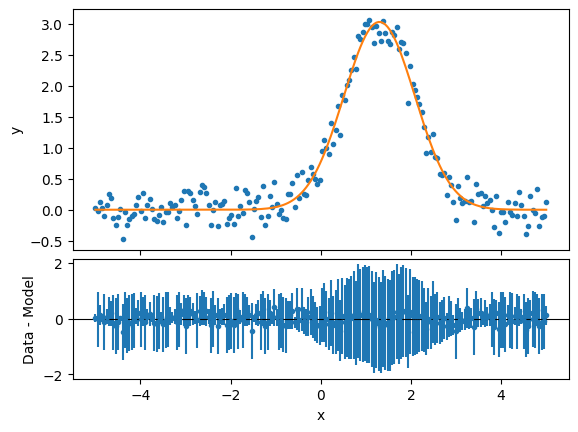

In [21]:
s.plot_fit_resid()

Let's hide the error bars in the residual plot too:

In [22]:
s.get_plot_prefs('resid')['yerrorbars'] = False

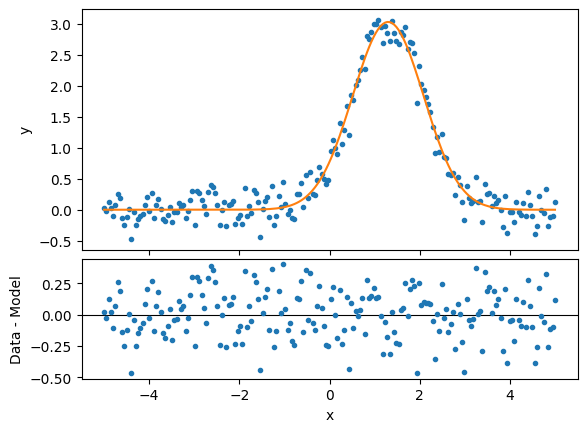

In [23]:
s.plot_fit_resid()

Hopefully this shows that you can just use the Session object to access the methods from the UI layer. Extending this example, we could ignore part of the data:

In [24]:
print("Statistic for all the data:     {}".format(s.calc_stat()))

s.ignore(-0.5, 0.7)

print("Statistic for some of the data: {}".format(s.calc_stat()))

Statistic for all the data:     7.3561697796074474
dataset 1: -5:5 -> -5:-0.527638,0.728643:5 x
Statistic for some of the data: 6.589041497213933


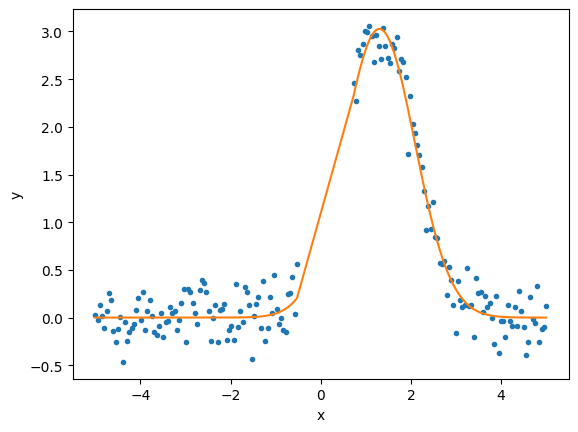

In [25]:
s.plot_fit()

Given that the data has changed, we can re-fit the model, but the difference is not large:

In [26]:
s.fit()

Dataset               = 1
Method                = levmar
Statistic             = leastsq
Initial fit statistic = 6.58904
Final fit statistic   = 6.5332 at function evaluation 24
Data points           = 176
Degrees of freedom    = 173
Change in statistic   = 0.0558438
   gmdl.fwhm      1.9067       +/- 0.27201     
   gmdl.pos       1.27195      +/- 0.123975    
   gmdl.ampl      3.02636      +/- 0.237525    


We can create a separate, completely independent, session (note that the sessions created by `sherpa.ui.utils.Session` and `sherpa.astro.ui.utils.Session` are also different):

In [27]:
s2 = Session()
print("Session 1 data: {}".format(s.list_data_ids()))
print("        2     : {}".format(s2.list_data_ids()))

Session 1 data: [1]
        2     : []


Changes to this new object do not affect the original session (unless you change any shared state, such as the model components):

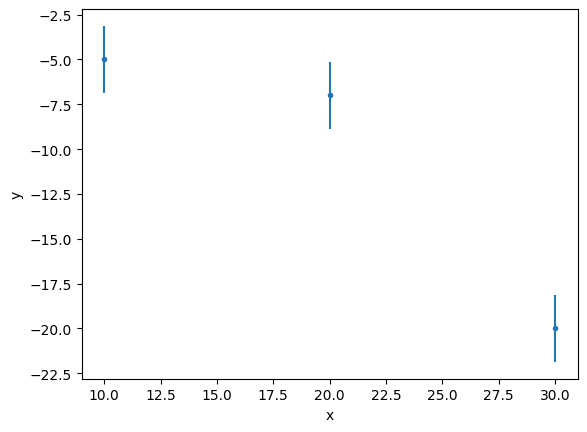

In [28]:
s2.load_arrays(1, [10, 20, 30], [-5, -7, -20])

s2.plot_data()

The original data is still present, as shown in the plot below.

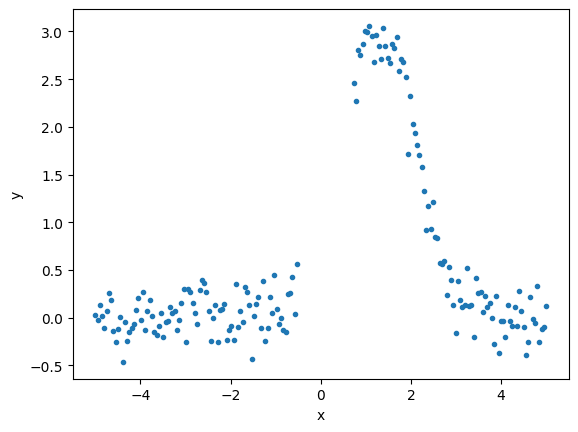

In [29]:
s.plot_data()

You can even overplot the data from the two sessions (although in this case it's not very illuminating, given that both data sets are fictitious): 

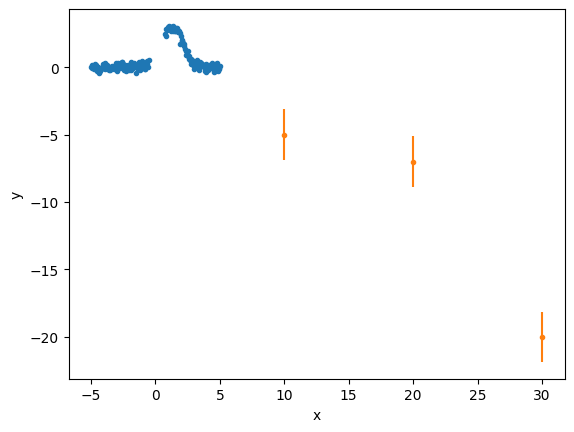

In [30]:
s.plot_data()
s2.plot_data(overplot=True)

Other choices - such as plot options (e.g. the lack of error bars for the original data) or choice of statistic (as shown below), are also stored in the session object.

In [31]:
print("Statistic choice: {} vs {}".format(s.get_stat_name(), s2.get_stat_name()))

Statistic choice: leastsq vs chi2gehrels


I have run out of simple things to run through here, but hopefully it has provided a starter for anyone who wants the convenience of the data management provided by the Sherpa UI layer but wants a bit-more control.